# Brain Tumor Segmentation with U-Net

This notebook trains a U-Net model to perform tumor segmentation on brain MRI scans.

In [4]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [5]:
# Paths
base_path = r"D:\IIT\Subjects\(4606)Machine Vision\CW\Develo\DataSet\U-Net\processed\split"
IMG_SIZE = 256
BATCH_SIZE = 8
EPOCHS = 15


In [6]:
def load_data(split):
    image_paths = sorted(glob(os.path.join(base_path, split, "images", "*", "*.png")))
    mask_paths = sorted(glob(os.path.join(base_path, split, "masks", "*", "*.png")))

    images, masks = [], []
    for img_path, msk_path in zip(image_paths, mask_paths):
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        msk = cv2.imread(msk_path, cv2.IMREAD_GRAYSCALE)

        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) / 255.0
        msk = cv2.resize(msk, (IMG_SIZE, IMG_SIZE)) / 255.0

        images.append(img[..., np.newaxis])
        masks.append(msk[..., np.newaxis])

    return np.array(images, dtype=np.float32), np.array(masks, dtype=np.float32)


In [7]:
X_train, y_train = load_data("train")
X_val, y_val = load_data("val")
X_test, y_test = load_data("test")

print("✅ Data loaded")
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")


✅ Data loaded
Train: (2994, 256, 256, 1), Val: (855, 256, 256, 1), Test: (429, 256, 256, 1)


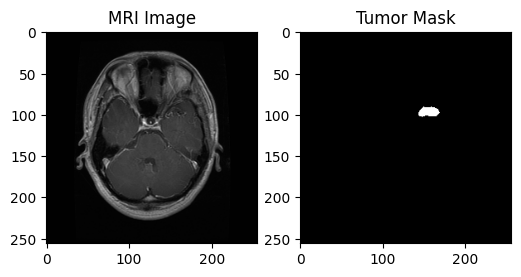

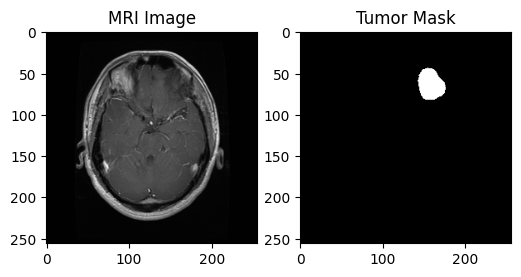

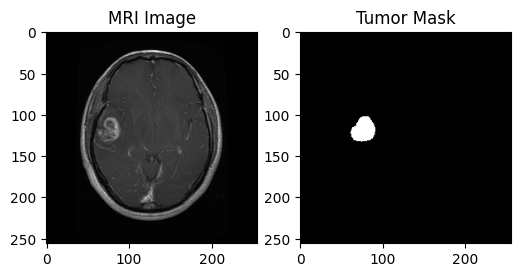

In [8]:
# Visualize a few samples
for i in range(3):
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1)
    plt.title("MRI Image")
    plt.imshow(X_train[i].squeeze(), cmap='gray')
    plt.subplot(1,2,2)
    plt.title("Tumor Mask")
    plt.imshow(y_train[i].squeeze(), cmap='gray')
    plt.show()


In [9]:
def unet(input_size=(256, 256, 1)):
    inputs = layers.Input(input_size)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(16, 3, activation='relu', padding='same')(c1)
    c1 = layers.Dropout(0.3)(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(32, 3, activation='relu', padding='same')(c2)
    c2 = layers.Dropout(0.3)(c2)
    p2 = layers.MaxPooling2D()(c2)

    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(p2)
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(c3)
    c3 = layers.Dropout(0.3)(c3)
    p3 = layers.MaxPooling2D()(c3)

    c4 = layers.Conv2D(128, 3, activation='relu', padding='same')(p3)
    c4 = layers.Conv2D(128, 3, activation='relu', padding='same')(c4)
    p4 = layers.MaxPooling2D()(c4)

    c5 = layers.Conv2D(256, 3, activation='relu', padding='same')(p4)
    c5 = layers.Conv2D(256, 3, activation='relu', padding='same')(c5)

    u6 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(128, 3, activation='relu', padding='same')(u6)
    c6 = layers.Conv2D(128, 3, activation='relu', padding='same')(c6)

    u7 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(64, 3, activation='relu', padding='same')(u7)
    c7 = layers.Conv2D(64, 3, activation='relu', padding='same')(c7)

    u8 = layers.Conv2DTranspose(32, 2, strides=2, padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(32, 3, activation='relu', padding='same')(u8)
    c8 = layers.Conv2D(32, 3, activation='relu', padding='same')(c8)

    u9 = layers.Conv2DTranspose(16, 2, strides=2, padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = layers.Conv2D(16, 3, activation='relu', padding='same')(u9)
    c9 = layers.Conv2D(16, 3, activation='relu', padding='same')(c9)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c9)
    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model


In [10]:
model = unet()
model.compile(optimizer=optimizers.Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

checkpoint = ModelCheckpoint("best_unet_model.keras", save_best_only=True, monitor='val_loss', mode='min')
earlystop = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=[checkpoint, earlystop])


Epoch 1/15


c:\Users\ridmi\.conda\envs\TenserFlow\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 256, 256, 1))
  warnings.warn(msg)


375/375 ━━━━━━━━━━━━━━━━━━━━ 253s 662ms/step - accuracy: 0.9355 - loss: 0.2884 - val_accuracy: 0.9841 - val_loss: 0.0694
Epoch 2/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 256s 684ms/step - accuracy: 0.9833 - loss: 0.0647 - val_accuracy: 0.9841 - val_loss: 0.0659
Epoch 3/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 258s 687ms/step - accuracy: 0.9840 - loss: 0.0552 - val_accuracy: 0.9841 - val_loss: 0.0577
Epoch 4/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 271s 724ms/step - accuracy: 0.9849 - loss: 0.0457 - val_accuracy: 0.9867 - val_loss: 0.0458
Epoch 5/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 255s 681ms/step - accuracy: 0.9881 - loss: 0.0378 - val_accuracy: 0.9888 - val_loss: 0.0428
Epoch 6/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 253s 676ms/step - accuracy: 0.9889 - loss: 0.0333 - val_accuracy: 0.9889 - val_loss: 0.0350
Epoch 7/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 255s 680ms/step - accuracy: 0.9898 - loss: 0.0292 - val_accuracy: 0.9887 - val_loss: 0.0332
Epoch 8/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 255s 679ms/step - accuracy: 0.9902 - loss: 0.02

In [11]:
loss, acc = model.evaluate(X_test, y_test)
print(f"\nTest Loss: {loss:.4f} | Test Accuracy: {acc:.4f}")


14/14 ━━━━━━━━━━━━━━━━━━━━ 10s 733ms/step - accuracy: 0.9898 - loss: 0.0279

Test Loss: 0.0202 | Test Accuracy: 0.9927


c:\Users\ridmi\.conda\envs\TenserFlow\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(5, 256, 256, 1))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 408ms/step


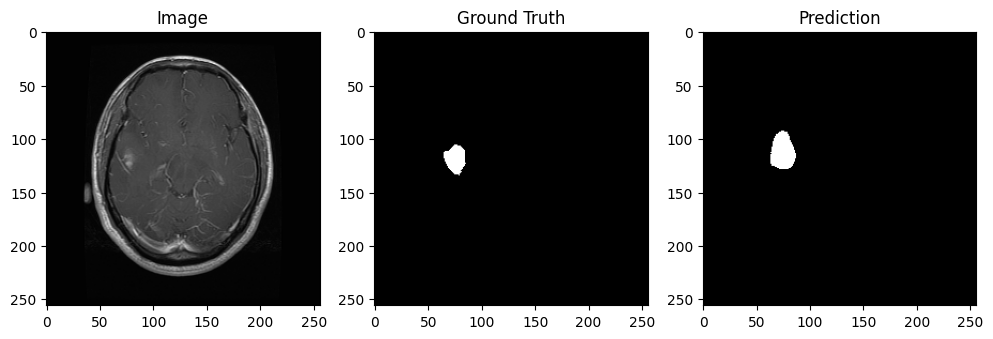

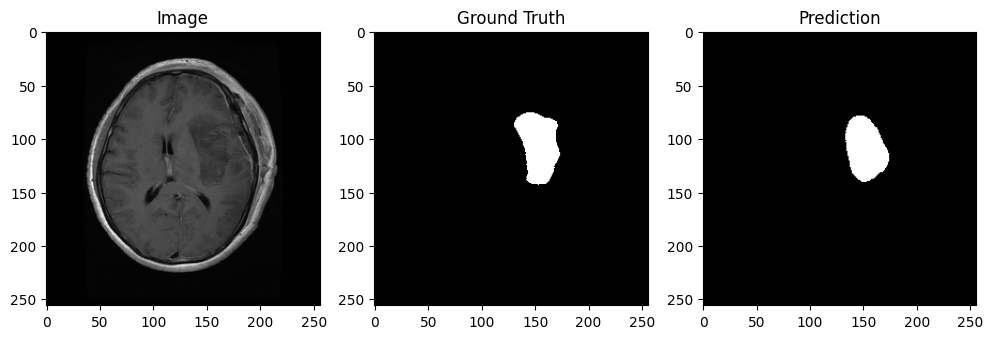

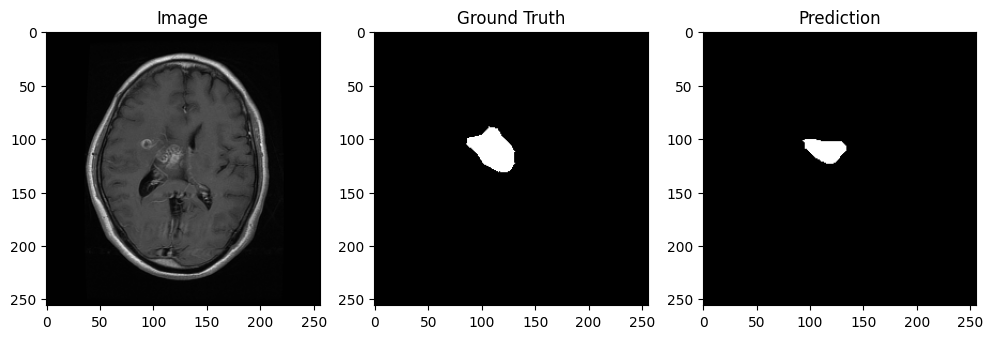

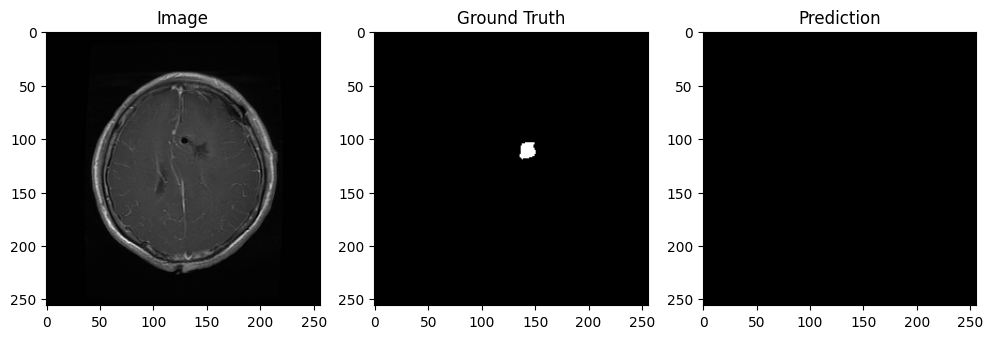

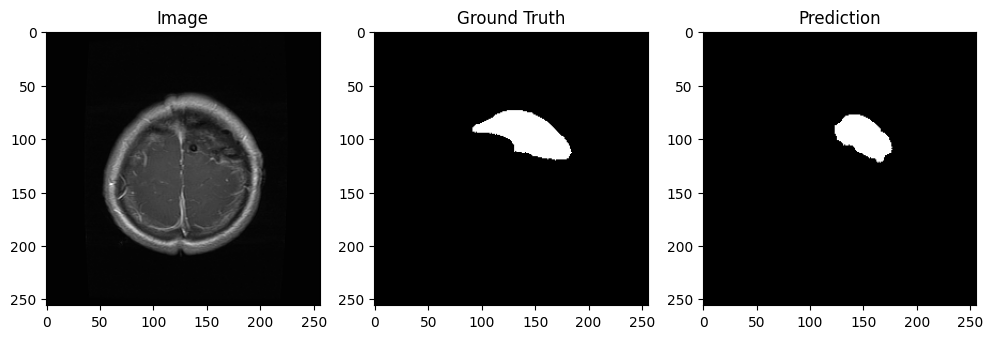

In [12]:
preds = model.predict(X_test[:5])
for i in range(5):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Image")
    plt.imshow(X_test[i].squeeze(), cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title("Ground Truth")
    plt.imshow(y_test[i].squeeze(), cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title("Prediction")
    plt.imshow((preds[i].squeeze() > 0.5).astype(np.uint8), cmap='gray')
    plt.show()


14/14 ━━━━━━━━━━━━━━━━━━━━ 9s 618ms/step
Dice Coefficient (F1): 0.6848
Intersection over Union (IoU): 0.5917
Pixel Accuracy: 0.9930


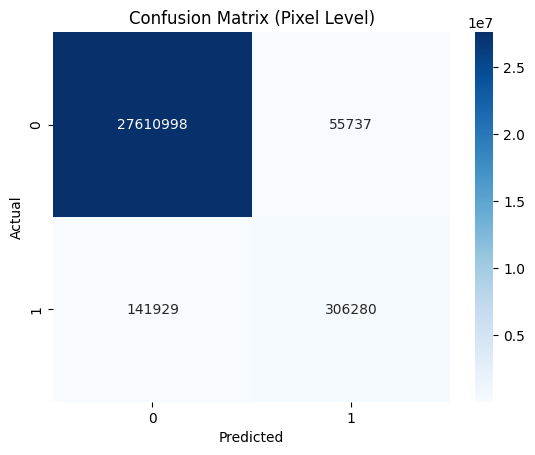

In [14]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import jaccard_score, f1_score
import seaborn as sns

def flatten_mask(mask_batch):
    return (mask_batch > 0.5).astype(np.uint8).reshape(mask_batch.shape[0], -1)

# Predict on test set
y_pred = model.predict(X_test)
y_pred_bin = (y_pred > 0.5).astype(np.uint8)

# Flatten masks for metric calculation
y_test_flat = flatten_mask(y_test)
y_pred_flat = flatten_mask(y_pred_bin)

# ---- Metrics ---- #
# 1. Dice Coefficient
dice = f1_score(y_test_flat, y_pred_flat, average='samples')
print(f"Dice Coefficient (F1): {dice:.4f}")

# 2. IoU
iou = jaccard_score(y_test_flat, y_pred_flat, average='samples')
print(f"Intersection over Union (IoU): {iou:.4f}")

# 3. Accuracy (binary pixel-wise)
pixel_acc = accuracy_score(y_test_flat.flatten(), y_pred_flat.flatten())
print(f"Pixel Accuracy: {pixel_acc:.4f}")

# 4. Confusion Matrix (pixel level)
conf = confusion_matrix(y_test_flat.flatten(), y_pred_flat.flatten())
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Pixel Level)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()